In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from scipy.special import gamma
from scipy.optimize import minimize, fsolve

## Problem 1

### Problem 1.c

In [2]:
# ITM of CDF of the shifted-exponetial distribution
def func_1c(U, beta=2, theta=3): return theta - beta*np.log(U)

In [3]:
# MLE variants for the theta or beta variant
def mle_theta(x:np.ndarray): return x.min()

def mle_beta(x:np.ndarray): return (x - mle_theta(x)).sum() / x.size

In [4]:
beta_true = 2
theta_true = 3

In [5]:
n = 1000
sim_collection = [0]*n

for i in range(n):
    samples = np.random.uniform(low=0, high=1, size=5)
    X = np.array([func_1c(u, beta=beta_true, theta=theta_true) for u in samples])

    sim_collection[i] = [mle_theta(X), mle_beta(X)]

sim_collection = np.array(sim_collection)

In [6]:
for idx, name in enumerate(['θ', 'β']):
    if name == 'θ': 
        true_og = theta_true
    else:
        true_og = beta_true
        
    print(f'{name} estimator state')
    a = sim_collection[:, idx].mean()
    b = sim_collection[:, idx].var()
    c = ((sim_collection[:, idx] - true_og)**2).mean()
    print(f'Mean:{round(a, 2)}\nVariance:{round(b, 2)}\nMSE:{round(c, 2)}')
    print()

θ estimator state
Mean:3.41
Variance:0.16
MSE:0.33

β estimator state
Mean:1.61
Variance:0.67
MSE:0.82



## Problem 2

### Problem 2.a

In [7]:
def weibull_pdf(x, alpha=2, theta=2): return (alpha*x**(alpha-1) / theta**alpha) * np.exp(-(x/theta)**alpha)

In [8]:
# ITM of CDF of the Weibull distribution
def func_2a(U, alpha=2, theta=2): return theta*((-np.log(1-U))**(1/alpha))

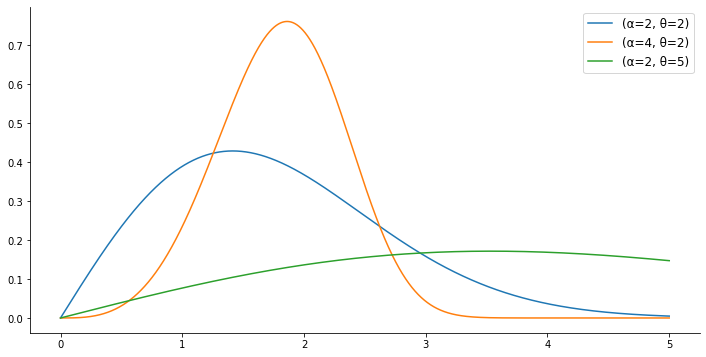

In [9]:
fig, ax = plt.subplots()
fig.set_figheight(6)
fig.set_figwidth(12)
ax.spines[['right', 'top']].set_visible(False)

X = np.linspace(0, 5, num=10000)
ax.plot(X, [weibull_pdf(i, alpha=2, theta=2) for i in X], label='(α=2, θ=2)')
ax.plot(X, [weibull_pdf(i, alpha=4, theta=2) for i in X], label='(α=4, θ=2)')
ax.plot(X, [weibull_pdf(i, alpha=2, theta=5) for i in X], label='(α=2, θ=5)')

ax.legend(fontsize=12)
plt.show()

### Problem 2.c

In [10]:
simulated_weibull = np.array([func_2a(i, alpha=1, theta=2) for i in np.random.uniform(0,1,50)])

In [11]:
simulated_weibull

array([ 7.25761522,  0.17465033,  5.89331842,  5.87469413,  0.12043684,
        0.34819106,  3.05080785,  0.37794582,  1.51738503,  1.269715  ,
        0.07352392,  3.38162446,  0.18890875,  2.5191931 ,  2.4233515 ,
        2.02037245,  0.64774517,  0.65641704,  1.05231151,  1.21485715,
        0.49420254,  6.57903423,  1.19114436,  1.03151247,  3.18186864,
        1.33405482,  0.50338867,  3.54175627,  2.93287905,  3.14560372,
        8.40678531,  5.80862671,  3.50760175,  0.02536349,  4.51100335,
        1.31849712,  0.54804684,  0.69776882,  1.92210168,  0.33735926,
        0.1976081 ,  0.57644403,  5.39178624,  0.28249136,  0.84349899,
        8.85142477,  0.18959631, 12.8253085 ,  0.1938403 ,  0.01686801])

### Problem 2.d

$log(L(\theta,\alpha;x))=nlog(\alpha) + (\alpha-1)\sum_{i=1}^nlog(x_i) - \sum_{i=1}^n (\frac{x_i}{\theta})^a - nlog(\theta)\alpha$

In [12]:
def neg_log_like(params, X):
    """
    Functional expression used for maximizing the log-likelihood
    **Note negative log-likelihood is choosen due to scipy minimize function**
    """
    alpha, theta = params
    n = X.size
    
    if alpha <= 0 or theta <= 0:  # Weibull parameters must be strictly positive
        return np.inf
        
    a1 = n * np.log(alpha)
    a2 = (alpha - 1) * np.log(X).sum()
    a3 = -((X / theta) ** alpha).sum()
    a4 = -n * alpha * np.log(theta)
    
    return -(a1 + a2 + a3 + a4)

In [13]:
initial_guess = [1, 2]

# Minimize the negative log-likelihood (i.e., maximize log-likelihood)
opt = minimize(
    fun=neg_log_like, 
    x0=initial_guess, 
    args=(simulated_weibull,), # Input for simultated data
    method='L-BFGS-B', 
    bounds=[(0.001, None), (0.001, None)] # Set bounds from 0 to infinity
)

mle_alpha, mle_theta = opt.x

In [14]:
print(f'Alpha est. {np.round(mle_alpha, 4)}\nTheta est. {np.round(mle_theta, 4)}', )

Alpha est. 0.815
Theta est. 2.1551


### Problem 2.e

$\frac{S^2}{\bar{X}^2}=\frac{\Gamma(1+2/\alpha)}{\Gamma(1+1/\alpha)^2}-1$

$\hat{\theta}=\frac{\bar{X}}{\Gamma(1+1/\alpha)}$

In [15]:
sample_mean = simulated_weibull.mean() 
sample_variance = simulated_weibull.var()

In [16]:
#Referenced alpha equation to numerically solve between theortical and sample moments 
def alpha_equation(alpha, sVar, sMean): return (gamma(1 + 2 / alpha) / (gamma(1 + 1 / alpha) ** 2)) - 1 - (sVar / sMean**2)

In [17]:
# Measures for alpha and theta estimation
alpha_hat = fsolve(
    func=alpha_equation,
    x0=[1],
    args=(sample_mean, sample_variance, ),
)[0]

theta_hat = sample_mean / gamma(1+ 1/alpha_hat)

In [18]:
print(f'Alpha est. {np.round(alpha_hat, 4)}\nTheta est. {np.round(theta_hat, 4)}', )

Alpha est. 5.7036
Theta est. 2.6041


## Problem 4

In [36]:
ibm_stock = pd.read_csv('IBM.csv').set_index('Date')

In [43]:
# calculate log-return for IBM stock
ibm_stock_logret = pd.DataFrame(
    data=np.log(ibm_stock).iloc[1:].values - np.log(ibm_stock).iloc[:-1].values, 
    index=ibm_stock.index.values[1:], 
    columns=['LogRets']
)

In [54]:
t = 1/365

### Problem 4.a

In [60]:
mle_var = ((ibm_stock_logret - ibm_stock_logret.mean())**2).sum().values[0] * 1 / (t*ibm_stock.size)
mle_mu  = ibm_stock_logret.mean().values[0] * t + (mle_var**2/2)

print(f'IBM Mean: {mle_mu}\nIBM Variance: {mle_var}')

IBM Mean: 0.0020902572755089163
IBM Variance: 0.0646385625554315


### Problem 4.b

In [59]:
print(f'Mu interval: {mle_mu-1.96*np.sqrt(mle_var/(t*ibm_stock.size))}, {mle_mu+1.96*np.sqrt(mle_var/(t*ibm_stock.size))}')
print(f'Var interval: {mle_var-1.96*np.sqrt((2*mle_var**2)/(t*ibm_stock.size))}, {mle_var+1.96*np.sqrt((2*mle_var**2)/(t*ibm_stock.size))}')

Mu interval: -0.5976291155843589, 0.6018096301353768
Var interval: -0.15099130739955602, 0.280268432510419


## Problem 5

In [21]:
citi_stock = pd.read_csv('C.csv').set_index('Date')

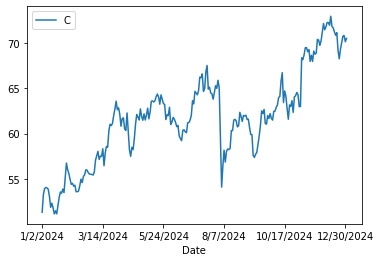

In [22]:
citi_stock.plot()
plt.show()